In [1]:
pip install statsmodels


The following command must be run outside of the IPython shell:

    $ pip install statsmodels

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, chi2, f
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r"C:\Users\USP\Desktop\MFE Sumemer Assignments\Used Data.csv")
y = pd.DataFrame(df["UN"] - df["RF"])
x = pd.DataFrame(df["MKT"] - df["RF"])

In [10]:
def ols(x,y):
    
    n = 264
    k = 1
    
    x_copy = x[:]
    a = np.ones((264))
    x = np.column_stack((a, x))
    x = pd.DataFrame(x)
    
    # PART A:
    
    #Calculate Betas
    betaMatrix = ((np.linalg.inv((x.transpose()).dot(x))).dot(x.transpose())).dot(y) 
    
    #Calculate Errors
    e = np.subtract(y,x.dot(betaMatrix)) 
    errorsSquared = np.power(e, 2) 
    
    # Calculate RSSs
    RSS = errorsSquared.sum(axis=0)  
    meanY= (y.mean(axis=0)).transpose()  
    TSS_1 = y - meanY
    TSS = (np.power(TSS_1,2).sum(axis=0))
    RsquaredY = 1-(RSS[0]/TSS[0]) 
    
    # Adjusted R-squared
    Rsquared_adjusted = 1 - ((1-RsquaredY)*(n-1))/(n-k-1)
    
    # Calculate Variance and Covariance
        
    variance = (errorsSquared.sum(axis=0))/n 
    covarianceMatrixY = variance[0]*(np.linalg.inv((x.transpose()).dot(x)))
    
    # standard error
    
    standarderror = np.sqrt(np.diag(covarianceMatrixY))
    
    # Part G, Hetero Cov-Var Matrix
    
    h1 = (np.linalg.inv((x.transpose()).dot(x))).dot(x.transpose())
    h2 = np.diag(np.diag(e.dot(e.transpose())))
    h3 = x.dot(((np.linalg.inv((x.transpose()).dot(x)))))

    hetero_cov_var = h1.dot(h2).dot(h3)
    
    # Part h, standard error under hetero
    
    standarderror_hetero = np.sqrt(np.diag(hetero_cov_var))
    
    # Part j, AIC, BIC, Hannah_Quinn
    
    log_liklihood = -(n/2)*np.log(2*np.pi) - (n/2)*np.log(variance[0]) - (1/(2*variance[0]))*RSS

    AIC = -2*log_liklihood + 2*(k+1)
      
    BIC = -2*log_liklihood + np.log(n)*(k+1)
    
    Hannah_Quinn = -2*log_liklihood + 2*(k+1)*np.log(np.log(n))
    
    # Part k, DW and BG
    
    # calculating difference of errors
    
    errors_diff = [np.power((e[0][i] - e[0][i-1]),2) for i in range(1, len(e[0]))] 
    
    DW = np.sum(errors_diff)/RSS
    
    # Breusch-Godfrey test
    
    numberOflags = 10
    meanEstimates = []
    betaMatrix_errors = np.zeros((n-numberOflags, numberOflags))
    for i in range(1,n-numberOflags+1):
        betaMatrix_errors[i-1,:] = (((np.linalg.inv((e.iloc[-i-numberOflags:-i].transpose()).dot(e.iloc[-i-numberOflags:-i]))).dot(e.iloc[-i-numberOflags:-i].transpose())).transpose()).dot(e.iloc[-i])
        meanEstimates.append(e.iloc[-i] - e.iloc[-i-numberOflags:-i].transpose().dot(betaMatrix_errors[i-1,:]))
    
    
    godfrey = 1 - (np.sum(np.power(meanEstimates,2)))/(np.sum(np.power(e[numberOflags:],2)))
    goffreyValue = godfrey*n
    
    # Part N
    # Ramsey RESET
    
    predValues = x.dot(betaMatrix)
    predNorm = (predValues - np.min(predValues))/(np.max(predValues) - np.min(predValues))
    new_df = pd.DataFrame(np.column_stack((x_copy,np.power(predNorm,2),np.power(predNorm,3),np.power(predNorm,4))))

    unrestrictedBetaMatrix = ((np.linalg.inv((new_df.transpose()).dot(new_df))).dot(new_df.transpose())).dot(y)
    unrestrictedErrors = y - new_df.dot(unrestrictedBetaMatrix)
    unrestrictedRSS = np.sum(np.power(unrestrictedErrors,2))
    F = ((RSS - unrestrictedRSS)/3)/(unrestrictedRSS/(264-(1+1)))
    p_value = 1-f.cdf(F, 3, 263)
    
    # Part O

    betaMatrix0 = np.zeros((204, len(x.columns)))
    for i in range(0,264-60):
        betaMatrix0[i,:] = (((np.linalg.inv((x[i:i+60].transpose()).dot(x[i:i+60]))).dot(x[i:i+60].transpose())).dot(y[i:i+60])).transpose() 
    
    return betaMatrix, RSS, RsquaredY, Rsquared_adjusted, covarianceMatrixY, standarderror,  hetero_cov_var, standarderror_hetero, AIC, BIC, Hannah_Quinn, DW, e, betaMatrix_errors, goffreyValue, p_value, betaMatrix0

## Question 1

In [11]:
betaMatrix, RSS, RsquaredY, Rsquared_adjusted, covarianceMatrixY, standarderror,  hetero_cov_var, standarderror_hetero, AIC, BIC, Hannah_Quinn, DW, e, betaMatrix_errors, goffreyValue, p_value, betaMatrix0 = ols(x,y)


In [12]:
print("Standard Error")
print(standarderror)
print("Residuals Sum of Squared")
print(RSS)

Standard Error
[0.00418134 0.09397699]
Residuals Sum of Squared
0    1.195721
dtype: float64


### a)

In [13]:
print("Beta Matrix Coefficients")
print(betaMatrix)

print("R Squared")
print(RsquaredY)

print("Adjusted R Squared")
print(Rsquared_adjusted)

Beta Matrix Coefficients
[[0.00804347]
 [0.0524295 ]]
R Squared
0.0011775864903335043
Adjusted R Squared
-0.002634712797871197


### b)

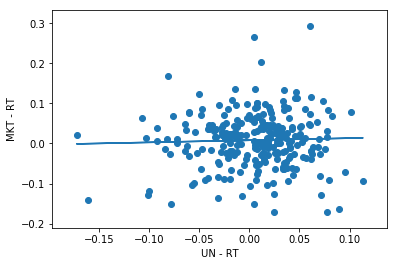

In [14]:
# Part B:
# Plotting

plt.scatter(x,y)
plt.plot(x[0], (betaMatrix[0] + betaMatrix[1]*x)[0])
plt.xlabel("UN - RT")
plt.ylabel("MKT - RT")
plt.show()

### c)

In [15]:
print("Covariance Matrix")
print(covarianceMatrixY)

Covariance Matrix
[[ 1.74836363e-05 -5.37728499e-05]
 [-5.37728499e-05  8.83167374e-03]]


### d) and i)

In [16]:
# Part D, I

def t_test(b, b0, se, n=None, k=None):
    
    # calculate t_test
    
    t=abs(b-b0)/se
    print("t-statistics Value")
    print(t)
    # critical values
    if n is None or k is None:
        critical_value_90= stats.norm.ppf(1-0.1/2)
        critical_value_95= stats.norm.ppf(1-0.05/2)
        critical_value_99= stats.norm.ppf(1-0.01/2)
    else:
        critical_value_90= stats.t.ppf(1-0.1/2, n-k)
        critical_value_95= stats.t.ppf(1-0.05/2, n-k)
        critical_value_99= stats.t.ppf(1-0.01/2, n-k)
        
    reject_null_90 = t > critical_value_90
    reject_null_95 = t > critical_value_95   
    reject_null_99 = t > critical_value_99
    
    print("Reject Null Hypothesis at confidence interval 90%")
    print(reject_null_90[0])
    print("Reject Null Hypothesis at confidence interval 95%")
    print(reject_null_95[0])
    print("Reject Null Hypothesis at confidence interval 99%")
    print(reject_null_99[0])
    
# Part D     
print("t-test for constant estimate with assumption of homoscedasticity")
t_test(betaMatrix[0],0, standarderror[0], n=264, k=1)
print("t-test for b1 estimate with assumption of homoscedasticity")
t_test(betaMatrix[1],0, standarderror[1], n=264, k=1)

# Part I
print("t-test for constant estimate with assumption of heteroscedasticity")
t_test(betaMatrix[0],0, standarderror_hetero[0], n=264, k=1)
print("t-test for b1 estimate with assumption of heteroscedasticity")
t_test(betaMatrix[1],0, standarderror_hetero[1], n=264, k=1)

t-test for constant estimate with assumption of homoscedasticity
t-statistics Value
[1.92365744]
Reject Null Hypothesis at confidence interval 90%
True
Reject Null Hypothesis at confidence interval 95%
False
Reject Null Hypothesis at confidence interval 99%
False
t-test for b1 estimate with assumption of homoscedasticity
t-statistics Value
[0.55789726]
Reject Null Hypothesis at confidence interval 90%
False
Reject Null Hypothesis at confidence interval 95%
False
Reject Null Hypothesis at confidence interval 99%
False
t-test for constant estimate with assumption of heteroscedasticity
t-statistics Value
[1.93175472]
Reject Null Hypothesis at confidence interval 90%
True
Reject Null Hypothesis at confidence interval 95%
False
Reject Null Hypothesis at confidence interval 99%
False
t-test for b1 estimate with assumption of heteroscedasticity
t-statistics Value
[0.46828235]
Reject Null Hypothesis at confidence interval 90%
False
Reject Null Hypothesis at confidence interval 95%
False
Reject

### e)

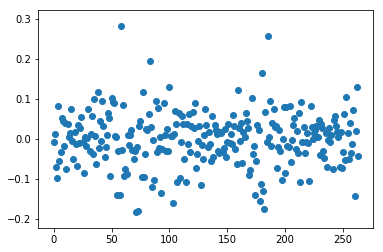

Conclusion:
There is no significant heteroskedasticity, due to the fact that there residuals error plot has no conical shape in the plot.


In [17]:
# Part E

n=264

plt.scatter(range(n),e)
plt.show()

print("Conclusion:\nThere is no significant heteroskedasticity, due to the fact that there residuals error plot has no conical shape in the plot.")

### f)

In [20]:
# Part F

# confidence interval

def CI(betaMatrix, se):
    for i in [0.95, 0.975, 0.995]:
        print("Confidence Interval at")
        print(i-(1-i))
        print("Confidence Interval of Constant coefficient")
        CI_lowerb0 = betaMatrix[0]-norm.ppf(i)*se[0]
        CI_upperb0 = betaMatrix[0]+norm.ppf(i)*se[0]
        print(CI_lowerb0)
        print(CI_upperb0)
        
        print("Confidence Interval of Beta-1 coefficient")
        CI_lowerb1 = betaMatrix[1]-norm.ppf(i)*se[1]
        CI_upperb1= betaMatrix[1]+norm.ppf(i)*se[1]
        print(CI_lowerb1)
        print(CI_upperb1)
        
        if(len(se)==3):
            print("Confidence Interval of Beta-1 coefficient")
            CI_lowerb2 = betaMatrix[2]-norm.ppf(i)*se[2]
            CI_upperb2= betaMatrix[2]+norm.ppf(i)*se[2]
            print(CI_lowerb2)
            print(CI_upperb2)

In [21]:
# Part F
CI(betaMatrix,standarderror)

Confidence Interval at
0.8999999999999999
Confidence Interval of Constant coefficient
[0.00116577]
[0.01492117]
Confidence Interval of Beta-1 coefficient
[-0.10214888]
[0.20700789]
Confidence Interval at
0.95
Confidence Interval of Constant coefficient
[-0.00015181]
[0.01623876]
Confidence Interval of Beta-1 coefficient
[-0.131762]
[0.23662101]
Confidence Interval at
0.99
Confidence Interval of Constant coefficient
[-0.00272695]
[0.0188139]
Confidence Interval of Beta-1 coefficient
[-0.18963917]
[0.29449818]


### g)

In [22]:
print("Covariance Matrix under the assumption of heteroscedasticity")
print(hetero_cov_var)

Covariance Matrix under the assumption of heteroscedasticity
[[ 1.73373722e-05 -5.30367346e-05]
 [-5.30367346e-05  1.25353337e-02]]


### h)

In [23]:
# Part H
CI(betaMatrix,standarderror_hetero)

Confidence Interval at
0.8999999999999999
Confidence Interval of Constant coefficient
[0.0011946]
[0.01489234]
Confidence Interval of Beta-1 coefficient
[-0.13173045]
[0.23658946]
Confidence Interval at
0.95
Confidence Interval of Constant coefficient
[-0.00011746]
[0.0162044]
Confidence Interval of Beta-1 coefficient
[-0.16701062]
[0.27186963]
Confidence Interval at
0.99
Confidence Interval of Constant coefficient
[-0.00268181]
[0.01876876]
Confidence Interval of Beta-1 coefficient
[-0.23596371]
[0.34082271]


### j)

In [24]:
print("Akaike Information Criterion")
print(AIC)
print("Bayesian Information Criterion")
print(BIC)
print("Hannah-Quinn Information Criterion")
print(Hannah_Quinn)

Akaike Information Criterion
0   -671.66123
dtype: float64
Bayesian Information Criterion
0   -664.509332
dtype: float64
Hannah-Quinn Information Criterion
0   -668.78738
dtype: float64


### k)

0    2.313946
dtype: float64
Breusch-Godfrey Value
0    264.0
dtype: float64
23.209251158954356
[-0.07534715 -0.00980562  0.03578813 -0.02838221  0.02610773  0.00861826
 -0.05224817  0.10290588 -0.01327722 -0.09274403]


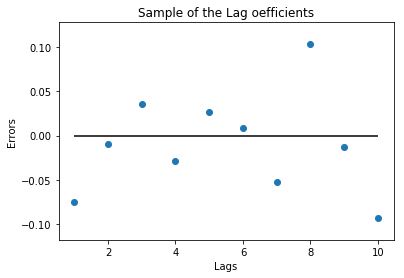

In [25]:
# Part k

print(DW)
print("Breusch-Godfrey Value")
print(goffreyValue) #this is for lag of 10
print(stats.chi2.ppf(0.99,10))
print(betaMatrix_errors[0,:]) # sample of lag coefficients for last error term
plt.scatter(np.linspace(1,10,10), betaMatrix_errors[0,:])
plt.hlines(0, 1, 10)
plt.title("Sample of the Lag oefficients")
plt.ylabel("Errors")
plt.xlabel("Lags")
plt.show()

The DW test gives a value greater than 2. This implies that there is some negative autocorrelation in play but we do not know any more information from this test.
The BG test gives a lagrange value of 264 which is greater than the chi squared critical value. Hence, the BG test implies that we reject the null hypothesis of uncorrelated error coefficients. This means that there exists autocorrelation in our error sample. The BG test was done with a lag of 10 errors.

### l)

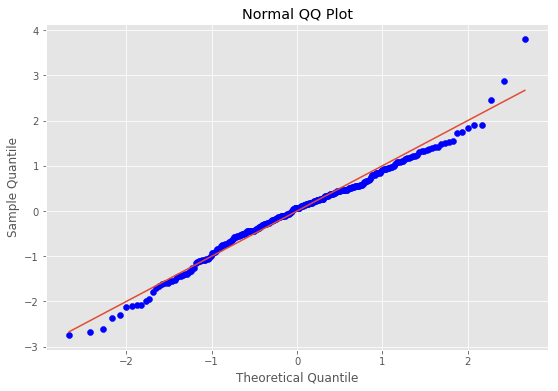

In [26]:
# Part L, QQ

n = 264

# sorting e in ascending order

e = pd.DataFrame(sorted(e[0]), columns = ["residuals"]) # sorting e in ascending order

# Calculating z score

e["z_score"] = (e["residuals"] - np.mean(e["residuals"]))/np.std(e["residuals"])

# rank and percentile

e["rank"] = e.index + 1

e["percentile"] = e["rank"]/n

# theoretical z score

e["theoretical"] = stats.norm.ppf(e["percentile"])

# Plotting QQ Plot

with plt.style.context("ggplot"):
    plt.figure(figsize=(9,6))
    plt.scatter(e["theoretical"], e["z_score"], color="b")
    plt.xlabel("Theoretical Quantile")
    plt.ylabel("Sample Quantile")
    plt.title("Normal QQ Plot")
    plt.plot(e["theoretical"], e["theoretical"])
    plt.show()


In [27]:
# Part L, Formal

n=264
k=1

# first cal skewness

e_mean = np.mean(e["residuals"])

e_avg1 = np.sum((e["residuals"] - e_mean)**3)/n

e_avg2 = (np.sum((e["residuals"] - e_mean)**2)/n)**(3/2)

g = e_avg1/e_avg2

skewness = g
print("Skewness")
print(skewness)

# Kurtosis

e_avg3 = np.sum((e["residuals"] - e_mean)**4)/n

e_avg4 = (np.sum((e["residuals"] - e_mean)**2)/n)**(4/2)

g = e_avg3/e_avg4

kurtosis = g

print("Kurtosis")
print(kurtosis)

# Calculate JB:

JB = ((n-k-1)/6)*((skewness**2) + (((kurtosis - 3)**2)/4) )
print("JB")
print(JB)

Skewness
0.1704760320094467
Kurtosis
4.604339446915913
JB
29.3675076322071


From observing the QQ plot, the errors do appear to be normally distributed.
Using the formal tests, the error terms are very slightly positively skewed, with a kurtosis slightly higher than that of the normal distribution, implying that the tails are slightly fatter than the normal distribution. The JB value is significantly higher than 0 and so the errors are not, in fact, normally distributed. They may be t distributed.

### m)

In [28]:
# part M, collinearity

# Variance Inflation Factor(VIF)

VIF = 1/ (1-RsquaredY)
print("Variance Inflation factor")
print(VIF)

Variance Inflation factor
1.0011789748351718


The VIF value is extremely close to 1 and therefore there is no collinearity.

### n)

In [29]:
# Part N
# using the Ramsey RESET test

print("p_value = ", p_value)
print("The p-value for our F-stat is 16.2%. Therefore, at 5% significance level, we fail to reject the Ramsey RESET test null hypothesis of correct specification. This indicates that the functional form is correct and our model does not suffer from omitted variables.")

p_value =  [0.16241017]
The p-value for our F-stat is 16.2%. Therefore, at 5% significance level, we fail to reject the Ramsey RESET test null hypothesis of correct specification. This indicates that the functional form is correct and our model does not suffer from omitted variables.


### o)

0.034978171120260484
0.08073182080324551


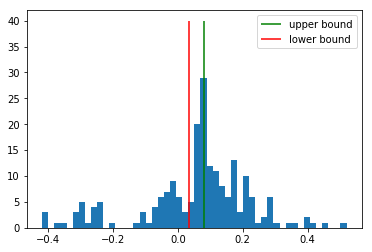

In [31]:
# Part O

#finding standard error
standError = np.sqrt((np.sum(np.power((betaMatrix0[:,1]- np.mean(betaMatrix0[:,1])),2))/len(betaMatrix0[:,1])))/np.sqrt(len(betaMatrix0[:,1]))

# 95% confidence interval
upperBound = np.mean(betaMatrix0[:,1]) + 1.96*standError
lowerBound = np.mean(betaMatrix0[:,1]) - 1.96*standError
print(lowerBound)
print(upperBound)

plt.hist(betaMatrix0[:,1], bins=50)
plt.vlines(upperBound, 0, 40, colors = "g", label = "upper bound")
plt.vlines(lowerBound, 0, 40, colors = "r", label = "lower bound")
plt.legend()
plt.show()

The beta coefficients when using a rolling 60 month regression are normally distributed as seen above from the graph. The upper and lower bounds of the 95% confidence interval are tight. As the sample size increases, expect this normality to continue showing because the distribution should approach an asymptotically normal distrbution.

## Question 2

In [32]:
x_new = df["HH"] - df["RF"]
x_df = pd.DataFrame(np.column_stack((x, x_new)))

betaMatrix, RSS, RsquaredY, Rsquared_adjusted, covarianceMatrixY, standarderror,  hetero_cov_var, standarderror_hetero, AIC, BIC, Hannah_Quinn, DW, e, betaMatrix_errors, goffreyValue, p_value, betaMatrix0 = ols(x_df,y)

In [33]:
print("Standard Error")
print(standarderror)
print("Residuals Sum of Squared")
print(RSS)

Standard Error
[0.00419203 0.11984826 0.12575123]
Residuals Sum of Squared
0    1.194118
dtype: float64


### a)

In [34]:
print("Beta Matrix Coefficients")
print(betaMatrix)

print("R Squared")
print(RsquaredY)

print("Adjusted R Squared")
print(Rsquared_adjusted)

Beta Matrix Coefficients
[[ 0.00824356]
 [ 0.09675669]
 [-0.07486515]]
R Squared
0.002516759233544441
Adjusted R Squared
-0.0012904287083121968


### b)

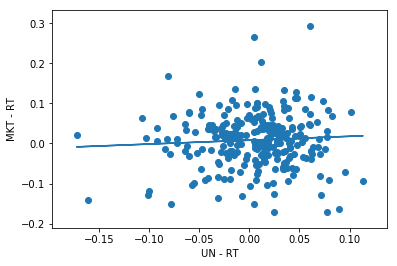

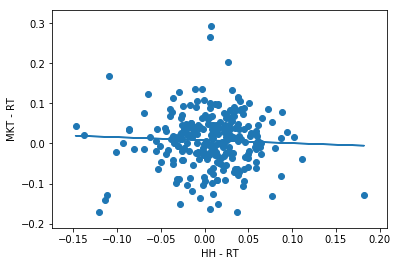

In [35]:
# Part B:
# Plotting
plt.scatter(x_df[0],y)
plt.plot(x_df[0], (betaMatrix[0] + betaMatrix[1][0]*x_df[0]))
plt.xlabel("UN - RT")
plt.ylabel("MKT - RT")
plt.show()

plt.scatter(x_df[1],y)
plt.plot(x_df[1], (betaMatrix[0] + betaMatrix[2][0]*x_df[1]))
plt.xlabel("HH - RT")
plt.ylabel("MKT - RT")
plt.show()

### c)

In [36]:
print("Covariance Matrix")
print(covarianceMatrixY)

Covariance Matrix
[[ 1.75731474e-05 -2.86771282e-05 -4.22629427e-05]
 [-2.86771282e-05  1.43636066e-02 -9.36299966e-03]
 [-4.22629427e-05 -9.36299966e-03  1.58133727e-02]]


### d) and i)

In [37]:
# Part D     
print("t-test for constant estimate with assumption of homoscedasticity")
t_test(betaMatrix[0],0, standarderror[0], n=264, k=1)
print("t-test for beta-1 estimate with assumption of homoscedasticity")
t_test(betaMatrix[1],0, standarderror[1], n=264, k=1)
print("t-test for beta-2 estimate with assumption of homoscedasticity")
t_test(betaMatrix[2],0, standarderror[2], n=264, k=1)

# Part I
print("t-test for constant estimate with assumption of heteroscedasticity")
t_test(betaMatrix[0],0, standarderror_hetero[0], n=264, k=1)
print("t-test for beta-1 estimate with assumption of heteroscedasticity")
t_test(betaMatrix[1],0, standarderror_hetero[1], n=264, k=1)
print("t-test for beta-2 estimate with assumption of heteroscedasticity")
t_test(betaMatrix[2],0, standarderror_hetero[2], n=264, k=1)

t-test for constant estimate with assumption of homoscedasticity
t-statistics Value
[1.96648185]
Reject Null Hypothesis at confidence interval 90%
True
Reject Null Hypothesis at confidence interval 95%
False
Reject Null Hypothesis at confidence interval 99%
False
t-test for beta-1 estimate with assumption of homoscedasticity
t-statistics Value
[0.80732662]
Reject Null Hypothesis at confidence interval 90%
False
Reject Null Hypothesis at confidence interval 95%
False
Reject Null Hypothesis at confidence interval 99%
False
t-test for beta-2 estimate with assumption of homoscedasticity
t-statistics Value
[0.59534329]
Reject Null Hypothesis at confidence interval 90%
False
Reject Null Hypothesis at confidence interval 95%
False
Reject Null Hypothesis at confidence interval 99%
False
t-test for constant estimate with assumption of heteroscedasticity
t-statistics Value
[1.94740291]
Reject Null Hypothesis at confidence interval 90%
True
Reject Null Hypothesis at confidence interval 95%
False


### e)

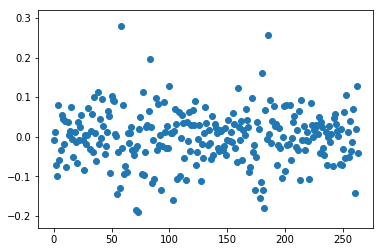

Conclusion:
There is no significant heteroskedasticity, due to the fact that there residuals error plot has no conical shape in the plot.


In [38]:
# Part E

n=264

plt.scatter(range(n),e)
plt.show()
print("Conclusion:\nThere is no significant heteroskedasticity, due to the fact that there residuals error plot has no conical shape in the plot.")


### f)

In [39]:
# Part F
CI(betaMatrix,standarderror)

Confidence Interval at
0.8999999999999999
Confidence Interval of Constant coefficient
[0.00134828]
[0.01513884]
Confidence Interval of Beta-1 coefficient
[-0.10037616]
[0.29388955]
Confidence Interval of Beta-1 coefficient
[-0.28170752]
[0.13197722]
Confidence Interval at
0.95
Confidence Interval of Constant coefficient
[2.73230974e-05]
[0.01645979]
Confidence Interval of Beta-1 coefficient
[-0.13814159]
[0.33165498]
Confidence Interval of Beta-1 coefficient
[-0.32133304]
[0.17160274]
Confidence Interval at
0.99
Confidence Interval of Constant coefficient
[-0.00255441]
[0.01904152]
Confidence Interval of Beta-1 coefficient
[-0.21195198]
[0.40546537]
Confidence Interval of Beta-1 coefficient
[-0.39877886]
[0.24904856]


### g)

In [40]:
print("Covariance Matrix underthe assumptionof heteroscedasticity")
print(hetero_cov_var)

Covariance Matrix underthe assumptionof heteroscedasticity
[[ 1.79191665e-05  3.63092230e-05 -1.45685176e-04]
 [ 3.63092230e-05  2.29124555e-02 -1.61751205e-02]
 [-1.45685176e-04 -1.61751205e-02  2.50740604e-02]]


### h)

In [41]:
# Part H
CI(betaMatrix,standarderror_hetero)

Confidence Interval at
0.8999999999999999
Confidence Interval of Constant coefficient
[0.00128072]
[0.01520639]
Confidence Interval of Beta-1 coefficient
[-0.15222251]
[0.3457359]
Confidence Interval of Beta-1 coefficient
[-0.33532429]
[0.18559398]
Confidence Interval at
0.95
Confidence Interval of Constant coefficient
[-5.31723302e-05]
[0.01654029]
Confidence Interval of Beta-1 coefficient
[-0.19992033]
[0.39343371]
Confidence Interval of Beta-1 coefficient
[-0.38522135]
[0.23549105]
Confidence Interval at
0.99
Confidence Interval of Constant coefficient
[-0.00266019]
[0.01914731]
Confidence Interval of Beta-1 coefficient
[-0.293143]
[0.48665639]
Confidence Interval of Beta-1 coefficient
[-0.48274234]
[0.33301203]


### j)

In [42]:
print("Akaike Information Criterion")
print(AIC)
print("Bayesian Information Criterion")
print(BIC)
print("Hannah-Quinn Information Criterion")
print(Hannah_Quinn)

Akaike Information Criterion
0   -672.015426
dtype: float64
Bayesian Information Criterion
0   -664.863528
dtype: float64
Hannah-Quinn Information Criterion
0   -669.141576
dtype: float64


### k)

0    2.281596
dtype: float64
Breusch-Godfrey Value
0    264.0
dtype: float64
23.209251158954356
[-0.07242076 -0.00860455  0.03599046 -0.02693763  0.02483055  0.00854216
 -0.04835257  0.09843266 -0.01329041 -0.08830549]


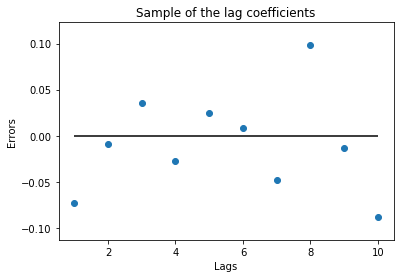

In [43]:
# Part k

print(DW)
print("Breusch-Godfrey Value")
print(goffreyValue) #this is for lag of 10
print(stats.chi2.ppf(0.99,10))
print(betaMatrix_errors[0,:]) # sample of lag coefficients for last error term
plt.scatter(np.linspace(1,10,10), betaMatrix_errors[0,:])
plt.hlines(0, 1, 10)
plt.title("Sample of the lag coefficients")
plt.ylabel("Errors")
plt.xlabel("Lags")
plt.show()

The DW test gives a value greater than 2. This implies that there is some negative autocorrelation in play but we do not know any more information from this test. The BG test gives a lagrange value of 264 which is greater than the chi squared critical value. Hence, the BG test implies that we reject the null hypothesis of uncorrelated error coefficients. This means that there exists autocorrelation in our error sample. The BG test was done with a lag of 10 errors.

### l)

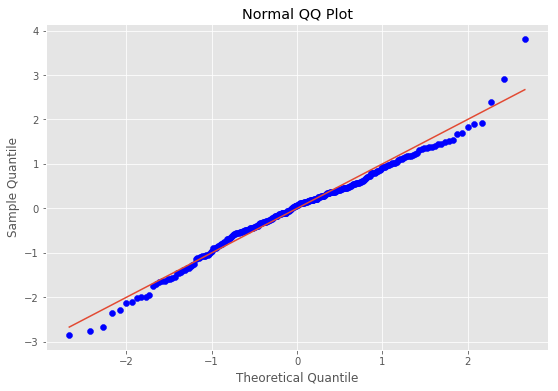

In [44]:
# Part L, QQ

n = 264

# sorting e in ascending order

e = pd.DataFrame(sorted(e[0]), columns = ["residuals"]) # sorting e in ascending order

# Calculating z score

e["z_score"] = (e["residuals"] - np.mean(e["residuals"]))/np.std(e["residuals"])

# rank and percentile

e["rank"] = e.index + 1

e["percentile"] = e["rank"]/n

# theoretical z score

e["theoretical"] = stats.norm.ppf(e["percentile"])

# Plotting QQ Plot

with plt.style.context("ggplot"):
    plt.figure(figsize=(9,6))
    plt.scatter(e["theoretical"], e["z_score"], color="b")
    plt.xlabel("Theoretical Quantile")
    plt.ylabel("Sample Quantile")
    plt.title("Normal QQ Plot")
    plt.plot(e["theoretical"], e["theoretical"])
    plt.show()


In [45]:
# Part L, Formal

n=264
k=1

# first cal skewness

e_mean = np.mean(e["residuals"])

e_avg1 = np.sum((e["residuals"] - e_mean)**3)/n

e_avg2 = (np.sum((e["residuals"] - e_mean)**2)/n)**(3/2)

g = e_avg1/e_avg2

skewness = g
print("Skewness")
print(skewness)

# Kurtosis

e_avg3 = np.sum((e["residuals"] - e_mean)**4)/n

e_avg4 = (np.sum((e["residuals"] - e_mean)**2)/n)**(4/2)

g = e_avg3/e_avg4

kurtosis = g

print("Kurtosis")
print(kurtosis)

# Calculate JB:

JB = ((n-k-1)/6)*((skewness**2) + (((kurtosis - 3)**2)/4) )

# Not that different from the OLS down 
print("JB")
print(JB)


Skewness
0.15356408479031847
Kurtosis
4.601989781500501
JB
29.04596378401991


From observing the QQ plot, the errors do appear to be normally distributed.
Using the formal tests, the error terms are very slightly positively skewed, with a kurtosis slightly higher than that of the normal distribution, implying that the tails are slightly fatter than the normal distribution. The JB value is significantly higher than 0 and so the errors are not, in fact, normally distributed. They may be t distributed.

### n)

In [46]:
# Part N
# using the Ramsey RESET test

print("p_value = ", p_value)
print("The p-value for our F-stat is 10.09%. Therefore, at 5% significance level, we fail to reject the Ramsey RESET test null hypothesis of correct specification. This indicates that the functional form is correct and our model does not suffer from omitted variables.")

p_value =  [0.10091031]
The p-value for our F-stat is 10.09%. Therefore, at 5% significance level, we fail to reject the Ramsey RESET test null hypothesis of correct specification. This indicates that the functional form is correct and our model does not suffer from omitted variables.


### o)

0.06697821783669576
0.151502718730405


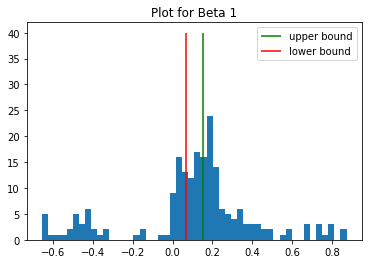

-0.08999097813729821
-0.013521275980060254


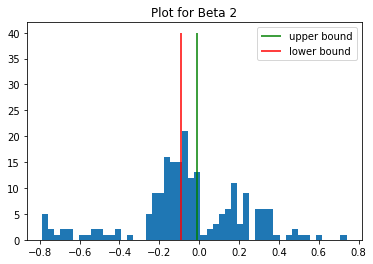

In [50]:
# Part O

# for beta1
#finding standard error
standError = np.sqrt((np.sum(np.power((betaMatrix0[:,1]- np.mean(betaMatrix0[:,1])),2))/len(betaMatrix0[:,1])))/np.sqrt(len(betaMatrix0[:,1]))

# 95% confidence interval
upperBound = np.mean(betaMatrix0[:,1]) + 1.96*standError
lowerBound = np.mean(betaMatrix0[:,1]) - 1.96*standError

print(lowerBound)
print(upperBound)

plt.hist(betaMatrix0[:,1], bins=50)
plt.vlines(upperBound, 0, 40, colors = "g", label = "upper bound")
plt.vlines(lowerBound, 0, 40, colors = "r", label = "lower bound")
plt.legend()
plt.title("Plot for Beta 1")
plt.show()

# for beta2
standError = np.sqrt((np.sum(np.power((betaMatrix0[:,2]- np.mean(betaMatrix0[:,2])),2))/len(betaMatrix0[:,2])))/np.sqrt(len(betaMatrix0[:,2]))

# 95% confidence interval
upperBound = np.mean(betaMatrix0[:,2]) + 1.96*standError
lowerBound = np.mean(betaMatrix0[:,2]) - 1.96*standError

print(lowerBound)
print(upperBound)

plt.hist(betaMatrix0[:,2], bins=50)
plt.vlines(upperBound, 0, 40, colors = "g", label = "upper bound")
plt.vlines(lowerBound, 0, 40, colors = "r", label = "lower bound")
plt.legend()
plt.title("Plot for Beta 2")
plt.show()

Both beta coefficients when using a rolling 60 month regression are normally distributed as seen above from the graphs. The upper and lower bounds of the 95% confidence interval are tight. As the sample size increases, expect this normality to continue showing because the distribution should approach an asymptotically normal distrbution.

### m)

In [52]:
# part M, collinearity

# Variance Inflation Factor(VIF)

# regress df["MKT"] - df["RF"] on df["HH"] - df["RF"]
ols(x,pd.DataFrame(x_new))

VIF = 1/(1-RsquaredY)
print("Variance Inflation Factor")
print(VIF)

Variance Inflation Factor
1.0025231092921527


The VIF value is pretty close to 1 and therefore this implies that no collinearity exists between the two independent variables. 